In [32]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import numpy as np

In [33]:
nPerClust = 300
blur = 1

A = [1,1]
B = [5, 1]
C = [4, 3]

a = [A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur]
b = [B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur]
c = [C[0]+np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur]

labels_np = np.hstack((np.zeros((nPerClust)), np.ones((nPerClust)), 1+np.ones((nPerClust))))

data_np = np.vstack((np.array(a).T, np.array(b).T, np.array(c).T))

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

datasetTrain = TensorDataset(X_train, y_train)
datasetTest = TensorDataset(X_test, y_test)

batch_size = 8
train_loader = DataLoader(datasetTrain, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(datasetTest, batch_size=datasetTest.tensors[0].shape[0])

In [34]:
def creatAnn(lr):
    class ANN(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(2,8)

            self.fc1 = nn.Linear(8,8)

            self.output = nn.Linear(8,3)



        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)
        
    net = ANN()
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    stepsize = batch_size*len(train_loader)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stepsize, gamma=1/2)
    
    return net, lossfun, optimizer, scheduler


In [35]:

def trainModel( lr_init, lr_dinymic=True):
    
    ann, lossfun, optimizer,scheduler = creatAnn(lr_init)
    
    testAcc = []
    currentLr = []
    
    for epoch in range(50):
        ann.train()
        for X,y in train_loader:
            y_pred = ann(X)
            
            loss = lossfun(y_pred,y)
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if lr_dinymic:
                scheduler.step()
            
            
        ann.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            y_pred = ann(X)
            
        testAcc.append(100*(torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item()))
        currentLr.append(scheduler.get_last_lr()[0])
        
    return testAcc, currentLr

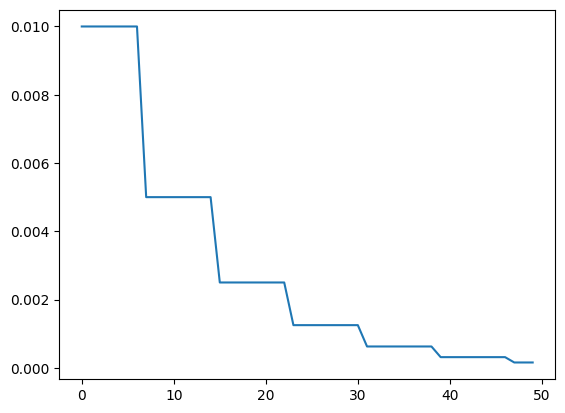

In [36]:
testTrue, lrTrue = trainModel(0.01, True)
testFalse, lrFalse = trainModel(0.01, False)

plt.plot(lrTrue)

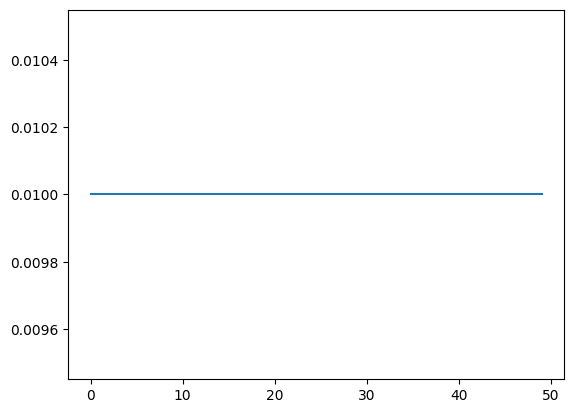

In [37]:
plt.plot(lrFalse)

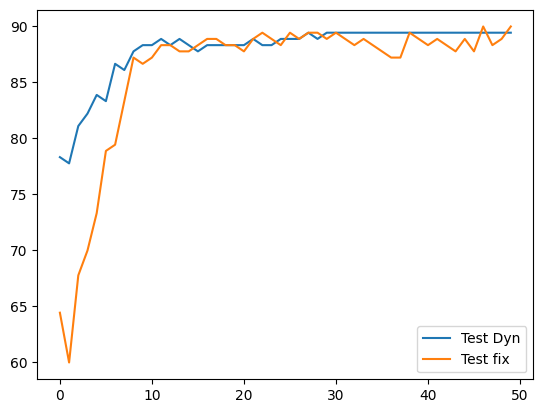

In [38]:
plt.plot(testTrue)
plt.plot(testFalse)
plt.legend(["Test Dyn", "Test fix"])